In [240]:
import polars as pl
from statsmodels.api import OLS
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import sys

sys.path.insert(0, 'crypto-datawarehouse\\src\\utils')

from cryptoviz import plot_viz

In [241]:
plot_viz()

viz


In [188]:
df = pl.read_parquet('..\\data\\candle_data.parquet').sort(by='tradetime')
close_std = df['close'].std()

In [189]:
df.head()

shape: (5, 8)
┌──────────┬──────────┬──────────┬──────────┬──────────┬───────────┬──────────────┬────────────┐
│ time     ┆ low      ┆ high     ┆ open     ┆ close    ┆ volume    ┆ tradetime    ┆ product_id │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---       ┆ ---          ┆ ---        │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64       ┆ datetime[μs] ┆ str        │
╞══════════╪══════════╪══════════╪══════════╪══════════╪═══════════╪══════════════╪════════════╡
│ 1.7129e9 ┆ 70164.4  ┆ 70261.81 ┆ 70255.51 ┆ 70235.64 ┆ 13.729609 ┆ 2024-04-12   ┆ BTC-USD    │
│          ┆          ┆          ┆          ┆          ┆           ┆ 01:40:00     ┆            │
│ 1.7129e9 ┆ 70233.02 ┆ 70335.79 ┆ 70240.02 ┆ 70315.36 ┆ 15.906281 ┆ 2024-04-12   ┆ BTC-USD    │
│          ┆          ┆          ┆          ┆          ┆           ┆ 01:45:00     ┆            │
│ 1.7129e9 ┆ 70251.96 ┆ 70321.72 ┆ 70313.83 ┆ 70278.73 ┆ 17.598059 ┆ 2024-04-12   ┆ BTC-USD    │
│          ┆          ┆          ┆          ┆          ┆           ┆ 01:50:00     ┆            │
│ 1.7129e9 ┆ 70264.16 ┆ 70341.55 ┆ 70272.6  ┆ 70295.12 ┆ 15.960638 ┆ 2024-04-12   ┆ BTC-USD    │
│          ┆          ┆          ┆          ┆          ┆           ┆ 01:55:00     ┆            │
│ 1.7129e9 ┆ 70212.0  ┆ 70323.59 ┆ 70295.12 ┆ 70315.99 ┆ 26.797077 ┆ 2024-04-12   ┆ BTC-USD    │
│          ┆          ┆          ┆          ┆          ┆           ┆ 02:00:00     ┆            │
└──────────┴──────────┴──────────┴──────────┴──────────┴───────────┴──────────────┴────────────┘

In [190]:
def linear_regression(df, x_col, y_col):
  """
  Performs linear regression on a Polars DataFrame.

  Args:
      df: The Polars DataFrame containing data.
      x_col: The column name for the independent variable (e.g., lagged price).
      y_col: The column name for the dependent variable (current close price).

  Returns:
      A statsmodels.api.OLS fitted model object.
  """
  model = OLS.from_formula(f"{y_col} ~ {x_col}", data=df)
  return model.fit()

In [191]:
lag = 70
model = linear_regression(df, f"close.shift({lag})", "close")
num_std = 1.5

In [192]:
# Extract slope and intercept from the fitted model
slope = model.params[f'close.shift({lag})']
intercept = model.params["Intercept"]

# Calculate standard deviation of residuals
std_dev = model.resid.std()

# Add new columns for upper and lower bands
df = df.with_columns(
    upper_band = df["close"].shift(lag) * slope + intercept + (num_std * std_dev))

df = df.with_columns(
    lower_band = df["close"].shift(lag) * slope + intercept - (num_std * std_dev))

df = df.with_columns(
    regline = df['close'].shift(lag) * slope + intercept
)

In [194]:
df.shape

(7199, 11)

In [193]:
df.head()

shape: (5, 11)
┌──────────┬──────────┬──────────┬──────────┬───┬────────────┬────────────┬────────────┬─────────┐
│ time     ┆ low      ┆ high     ┆ open     ┆ … ┆ product_id ┆ upper_band ┆ lower_band ┆ regline │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---     │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ str        ┆ f64        ┆ f64        ┆ f64     │
╞══════════╪══════════╪══════════╪══════════╪═══╪════════════╪════════════╪════════════╪═════════╡
│ 1.7129e9 ┆ 70164.4  ┆ 70261.81 ┆ 70255.51 ┆ … ┆ BTC-USD    ┆ null       ┆ null       ┆ null    │
│ 1.7129e9 ┆ 70233.02 ┆ 70335.79 ┆ 70240.02 ┆ … ┆ BTC-USD    ┆ null       ┆ null       ┆ null    │
│ 1.7129e9 ┆ 70251.96 ┆ 70321.72 ┆ 70313.83 ┆ … ┆ BTC-USD    ┆ null       ┆ null       ┆ null    │
│ 1.7129e9 ┆ 70264.16 ┆ 70341.55 ┆ 70272.6  ┆ … ┆ BTC-USD    ┆ null       ┆ null       ┆ null    │
│ 1.7129e9 ┆ 70212.0  ┆ 70323.59 ┆ 70295.12 ┆ … ┆ BTC-USD    ┆ null       ┆ null       ┆ null    │
└──────────┴──────────┴──────────┴──────────┴───┴────────────┴────────────┴────────────┴─────────┘

In [195]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df["tradetime"], y=df["close"], name="Close",  mode='lines'),
    secondary_y=False,
)

fig.add_trace(go.Scatter(x=df["tradetime"], y=df["upper_band"], name=f"Upper Bank", mode='lines'))

fig.add_trace(go.Scatter(x=df["tradetime"], y=df["lower_band"], name=f"Lower Band", mode='lines'))

fig.add_trace(go.Scatter(x=df["tradetime"], y=df["regline"], name=f"Regression Line", mode='lines'))

fig.add_trace(
    go.Scatter(
        x=df["tradetime"],
        y=df["lower_band"],
        fill="tonexty",
        fillcolor="rgba(0,176,246,0.2)",
        line_color="rgba(255,255,255,0)",
        name="Premium",
        showlegend=False,
    )
)

fig.add_trace(
    go.Scatter(
        x=df["tradetime"],
        y=df["upper_band"],
        fill="tonexty",
        fillcolor="rgba(0,176,246,0.2)",
        line_color="rgba(255,255,255,0)",
        name="Upper Band Fill",
        showlegend=False,
    )
)

# Add figure title
fig.update_layout(title_text="BTC-USD w/ Indicators")

# Set x-axis title
fig.update_xaxes(title_text="Tradetime (5 min. intervals)")

# Set y-axes titles
fig.update_yaxes(title_text="BTC-USD ($)", secondary_y=False)
# fig.update_yaxes(title_text="<b>secondary</b> yaxis title", secondary_y=True)

fig.show()

In [198]:
dfs = df.with_columns(signal = pl.lit('hold'))
dfs = dfs.with_columns(prev_close = pl.col('close').shift())

dfs = dfs.with_columns(
        signal = pl.when((pl.col('close') > pl.col('upper_band')) & (pl.col('prev_close') < pl.col('upper_band')))
        .then(pl.lit('sell'))
        .otherwise(pl.col('signal'))
    )

dfs = dfs.with_columns(
        signal = pl.when((pl.col('close') < pl.col('lower_band')) & (pl.col('prev_close') > pl.col('lower_band')))
        .then(pl.lit('buy'))
        .otherwise(pl.col('signal'))
    )



In [199]:
signals_df = dfs.filter(pl.col('signal') != 'hold')
signals_df.head()

shape: (5, 13)
┌──────────┬──────────┬──────────┬──────────┬───┬──────────────┬─────────────┬────────┬────────────┐
│ time     ┆ low      ┆ high     ┆ open     ┆ … ┆ lower_band   ┆ regline     ┆ signal ┆ prev_close │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---          ┆ ---         ┆ ---    ┆ ---        │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64          ┆ f64         ┆ str    ┆ f64        │
╞══════════╪══════════╪══════════╪══════════╪═══╪══════════════╪═════════════╪════════╪════════════╡
│ 1.7129e9 ┆ 68102.22 ┆ 68528.82 ┆ 68502.15 ┆ … ┆ 68426.935533 ┆ 69881.88643 ┆ buy    ┆ 68503.97   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 4           ┆        ┆            │
│ 1.7130e9 ┆ 66936.0  ┆ 67222.25 ┆ 67221.01 ┆ … ┆ 67004.653157 ┆ 68459.60405 ┆ buy    ┆ 67221.01   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 8           ┆        ┆            │
│ 1.7130e9 ┆ 66850.0  ┆ 67154.0  ┆ 67152.35 ┆ … ┆ 67108.210882 ┆ 68563.16178 ┆ buy    ┆ 67158.04   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 3           ┆        ┆            │
│ 1.7130e9 ┆ 66850.3  ┆ 67006.63 ┆ 66981.84 ┆ … ┆ 66918.631804 ┆ 68373.58270 ┆ buy    ┆ 66986.19   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 5           ┆        ┆            │
│ 1.7130e9 ┆ 67376.33 ┆ 67489.93 ┆ 67376.33 ┆ … ┆ 64534.449538 ┆ 65989.40043 ┆ sell   ┆ 67376.86   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 9           ┆        ┆            │
└──────────┴──────────┴──────────┴──────────┴───┴──────────────┴─────────────┴────────┴────────────┘

In [200]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df["tradetime"], y=df["close"], name="Close",  mode='lines'),
    secondary_y=False,
)

fig.add_trace(go.Scatter(x=df["tradetime"], y=df["upper_band"], name=f"Upper Bank", mode='lines'))

fig.add_trace(go.Scatter(x=df["tradetime"], y=df["lower_band"], name=f"Lower Band", mode='lines'))

fig.add_trace(go.Scatter(x=df["tradetime"], y=df["regline"], name=f"Regression Line", mode='lines'))


def color_map(val):
    if val == 'buy':
        return 'green'
    elif val == 'sell':
        return 'red'
    else:
        return 'gray'

fig.add_trace(
    go.Scatter(x=signals_df['tradetime'],
                y = signals_df['close'],
                mode="markers", 
                customdata=signals_df['signal'],
                marker=dict(color=[color_map(val) for val in signals_df['signal']]),
                name = 'BUY/SELL Signal'
                )
            )


# Add figure title
fig.update_layout(title_text="BTC-USD w/ Indicators")

# Set x-axis title
fig.update_xaxes(title_text="Tradetime (5 min. intervals)")

# Set y-axes titles
fig.update_yaxes(title_text="BTC-USD ($)", secondary_y=False)
# fig.update_yaxes(title_text="<b>secondary</b> yaxis title", secondary_y=True)

fig.show()

In [201]:
# Show strategy outcome
initial_amount = 10000.00 # Principal in dollars ($)
balance = initial_amount
n_assets = 0 # start with 0 assets 

In [202]:
dfs.head()

shape: (5, 13)
┌──────────┬──────────┬──────────┬──────────┬───┬────────────┬─────────┬────────┬────────────┐
│ time     ┆ low      ┆ high     ┆ open     ┆ … ┆ lower_band ┆ regline ┆ signal ┆ prev_close │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---        ┆ ---     ┆ ---    ┆ ---        │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64        ┆ f64     ┆ str    ┆ f64        │
╞══════════╪══════════╪══════════╪══════════╪═══╪════════════╪═════════╪════════╪════════════╡
│ 1.7129e9 ┆ 70164.4  ┆ 70261.81 ┆ 70255.51 ┆ … ┆ null       ┆ null    ┆ hold   ┆ null       │
│ 1.7129e9 ┆ 70233.02 ┆ 70335.79 ┆ 70240.02 ┆ … ┆ null       ┆ null    ┆ hold   ┆ 70235.64   │
│ 1.7129e9 ┆ 70251.96 ┆ 70321.72 ┆ 70313.83 ┆ … ┆ null       ┆ null    ┆ hold   ┆ 70315.36   │
│ 1.7129e9 ┆ 70264.16 ┆ 70341.55 ┆ 70272.6  ┆ … ┆ null       ┆ null    ┆ hold   ┆ 70278.73   │
│ 1.7129e9 ┆ 70212.0  ┆ 70323.59 ┆ 70295.12 ┆ … ┆ null       ┆ null    ┆ hold   ┆ 70295.12   │
└──────────┴──────────┴──────────┴──────────┴───┴────────────┴─────────┴────────┴────────────┘

In [203]:
timeline_df = dfs.select(pl.col('tradetime'), pl.col('close'), pl.col('signal')).to_pandas().sort_values(by = 'tradetime')
timeline_df.shape


(7199, 3)

In [204]:
timeline_df

tradetime     close signal
0    2024-04-12 01:40:00  70235.64   hold
1    2024-04-12 01:45:00  70315.36   hold
2    2024-04-12 01:50:00  70278.73   hold
3    2024-04-12 01:55:00  70295.12   hold
4    2024-04-12 02:00:00  70315.99   hold
...                  ...       ...    ...
7194 2024-05-07 01:10:00  63699.47   hold
7195 2024-05-07 01:15:00  63701.37   hold
7196 2024-05-07 01:20:00  63620.59   hold
7197 2024-05-07 01:25:00  63569.73   hold
7198 2024-05-07 01:30:00  63634.30   hold

[7199 rows x 3 columns]

In [227]:
# implement trade logic on signals

trade_log = {}
for idx, row in timeline_df.iterrows():
    signal = row['signal']
    close = row['close']
    tradetime = row['tradetime']

    if (signal == 'buy') & (balance > 0):       
        n_assets = balance / close 
        balance -= n_assets * close

        trade_log[tradetime] = ['buy', close, n_assets, balance]

    elif (signal == 'sell') & (n_assets > 0):
        balance = n_assets * close
        n_assets = 0
        trade_log[tradetime] = ['sell', close, n_assets, balance]

    else:
        next 

if list(trade_log.values())[-1][0] == 'buy':
    trade_log[tradetime] = ['sell', close, 0, n_assets * close]

In [229]:
trades = (
    pd.DataFrame.from_dict(
        trade_log, orient="index", columns=["action", "price", "quantity", "balance"]
    )
    .reset_index()
    .rename(columns={"index": "tradetime"})
)

In [230]:
final_balance = trades.tail(1)['balance']

trading_return = (final_balance - initial_amount) / initial_amount * 100

In [231]:
trading_return

14    25.714525
Name: balance, dtype: float64

<Axes: xlabel='tradetime'>

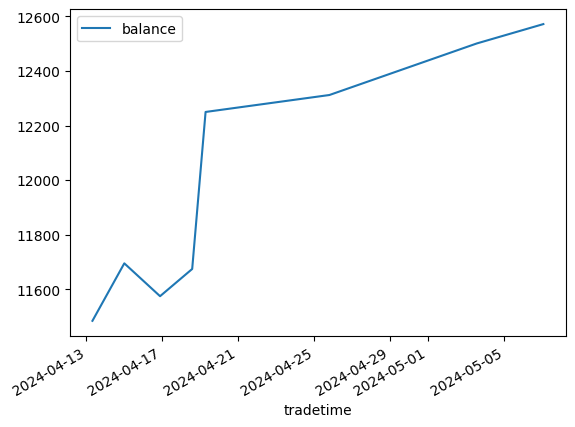

In [232]:
trades[trades['balance'] > 0].plot(x='tradetime',y='balance')

In [213]:
trades[trades['balance'] > 0]['balance'].mean()

10278.25076207404

In [183]:
dfs2 = df.with_columns(signal = pl.lit('hold'))
dfs2 = dfs2.with_columns(prev_close = pl.col('close').shift())

dfs2 = dfs2.with_columns(
        signal = pl.when((pl.col('close') > pl.col('upper_band')) & (pl.col('prev_close') < pl.col('upper_band')))
        .then(pl.lit('sell'))
        .otherwise(pl.col('signal'))
    )

dfs2 = dfs2.with_columns(
        signal = pl.when((pl.col('close') < pl.col('lower_band')) & (pl.col('prev_close') > pl.col('lower_band')))
        .then(pl.lit('buy'))
        .otherwise(pl.col('signal'))
    )

In [184]:
dfs2

shape: (4_320, 13)
┌──────────┬──────────┬──────────┬──────────┬───┬──────────────┬─────────────┬────────┬────────────┐
│ time     ┆ low      ┆ high     ┆ open     ┆ … ┆ lower_band   ┆ regline     ┆ signal ┆ prev_close │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---          ┆ ---         ┆ ---    ┆ ---        │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64          ┆ f64         ┆ str    ┆ f64        │
╞══════════╪══════════╪══════════╪══════════╪═══╪══════════════╪═════════════╪════════╪════════════╡
│ 1.7126e9 ┆ 71461.93 ┆ 71533.53 ┆ 71511.95 ┆ … ┆ null         ┆ null        ┆ hold   ┆ null       │
│ 1.7126e9 ┆ 71461.18 ┆ 71534.54 ┆ 71483.58 ┆ … ┆ null         ┆ null        ┆ hold   ┆ 71483.43   │
│ 1.7126e9 ┆ 71365.91 ┆ 71497.06 ┆ 71482.64 ┆ … ┆ null         ┆ null        ┆ hold   ┆ 71477.15   │
│ 1.7126e9 ┆ 71396.54 ┆ 71440.71 ┆ 71416.92 ┆ … ┆ null         ┆ null        ┆ hold   ┆ 71420.61   │
│ 1.7126e9 ┆ 71410.84 ┆ 71605.86 ┆ 71425.08 ┆ … ┆ null         ┆ null        ┆ hold   ┆ 71425.48   │
│ …        ┆ …        ┆ …        ┆ …        ┆ … ┆ …            ┆ …           ┆ …      ┆ …          │
│ 1.7139e9 ┆ 66553.83 ┆ 66641.42 ┆ 66608.67 ┆ … ┆ 64544.930536 ┆ 66173.71881 ┆ hold   ┆ 66609.53   │
│ 1.7139e9 ┆ 66453.0  ┆ 66595.17 ┆ 66567.46 ┆ … ┆ 64553.373249 ┆ 66182.16152 ┆ hold   ┆ 66565.65   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 3           ┆        ┆            │
│ 1.7139e9 ┆ 66560.35 ┆ 66633.81 ┆ 66585.98 ┆ … ┆ 64546.795787 ┆ 66175.58406 ┆ hold   ┆ 66585.98   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 1           ┆        ┆            │
│ 1.7139e9 ┆ 66594.66 ┆ 66658.18 ┆ 66624.18 ┆ … ┆ 64526.27803  ┆ 66155.06630 ┆ hold   ┆ 66621.76   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 5           ┆        ┆            │
│ 1.7139e9 ┆ 66606.0  ┆ 66646.13 ┆ 66640.97 ┆ … ┆ 64596.095519 ┆ 66224.88379 ┆ hold   ┆ 66640.97   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 3           ┆        ┆            │
└──────────┴──────────┴──────────┴──────────┴───┴──────────────┴─────────────┴────────┴────────────┘

In [185]:
signals_df2 = dfs2.filter(pl.col('signal') != 'hold')
signals_df2

shape: (36, 13)
┌──────────┬──────────┬──────────┬──────────┬───┬──────────────┬─────────────┬────────┬────────────┐
│ time     ┆ low      ┆ high     ┆ open     ┆ … ┆ lower_band   ┆ regline     ┆ signal ┆ prev_close │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---          ┆ ---         ┆ ---    ┆ ---        │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64          ┆ f64         ┆ str    ┆ f64        │
╞══════════╪══════════╪══════════╪══════════╪═══╪══════════════╪═════════════╪════════╪════════════╡
│ 1.7127e9 ┆ 68200.0  ┆ 68745.75 ┆ 68681.92 ┆ … ┆ 68643.376862 ┆ 70272.16513 ┆ buy    ┆ 68685.22   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 6           ┆        ┆            │
│ 1.7128e9 ┆ 69120.38 ┆ 69243.97 ┆ 69137.81 ┆ … ┆ 65974.13192  ┆ 67602.92019 ┆ sell   ┆ 69141.97   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 4           ┆        ┆            │
│ 1.7128e9 ┆ 69232.92 ┆ 69388.99 ┆ 69232.92 ┆ … ┆ 65994.828169 ┆ 67623.61644 ┆ sell   ┆ 69232.17   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 3           ┆        ┆            │
│ 1.7128e9 ┆ 70561.03 ┆ 70808.72 ┆ 70561.03 ┆ … ┆ 67332.480557 ┆ 68961.26883 ┆ sell   ┆ 70569.78   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 1           ┆        ┆            │
│ 1.7128e9 ┆ 70417.08 ┆ 70574.95 ┆ 70423.84 ┆ … ┆ 67176.18327  ┆ 68804.97154 ┆ sell   ┆ 70425.51   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 4           ┆        ┆            │
│ …        ┆ …        ┆ …        ┆ …        ┆ … ┆ …            ┆ …           ┆ …      ┆ …          │
│ 1.7135e9 ┆ 63703.58 ┆ 63955.23 ┆ 63722.0  ┆ … ┆ 60475.444679 ┆ 62104.23295 ┆ sell   ┆ 63723.82   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 3           ┆        ┆            │
│ 1.7135e9 ┆ 61650.0  ┆ 62186.97 ┆ 62086.46 ┆ … ┆ 61902.057916 ┆ 63530.84619 ┆ buy    ┆ 62087.61   │
│ 1.7135e9 ┆ 62106.54 ┆ 62332.82 ┆ 62289.92 ┆ … ┆ 62155.053719 ┆ 63783.84199 ┆ buy    ┆ 62291.33   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 3           ┆        ┆            │
│ 1.7135e9 ┆ 61897.93 ┆ 62209.2  ┆ 62150.88 ┆ … ┆ 62071.652922 ┆ 63700.44119 ┆ buy    ┆ 62151.28   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 7           ┆        ┆            │
│ 1.7135e9 ┆ 63911.85 ┆ 64934.04 ┆ 63977.33 ┆ … ┆ 61213.04864  ┆ 62841.83691 ┆ sell   ┆ 63983.28   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 5           ┆        ┆            │
└──────────┴──────────┴──────────┴──────────┴───┴──────────────┴─────────────┴────────┴────────────┘

In [186]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df["tradetime"], y=df["close"], name="Close",  mode='lines'),
    secondary_y=False,
)

fig.add_trace(go.Scatter(x=df["tradetime"], y=df["upper_band"], name=f"Upper Bank", mode='lines'))

fig.add_trace(go.Scatter(x=df["tradetime"], y=df["lower_band"], name=f"Lower Band", mode='lines'))

fig.add_trace(go.Scatter(x=df["tradetime"], y=df["regline"], name=f"Regression Line", mode='lines'))


def color_map(val):
    if val == 'buy':
        return 'green'
    elif val == 'sell':
        return 'red'
    else:
        return 'gray'

fig.add_trace(
    go.Scatter(x=signals_df2['tradetime'],
                y = signals_df2['close'],
                mode="markers", 
                customdata=signals_df['signal'],
                marker=dict(color=[color_map(val) for val in signals_df2['signal']]),
                name = 'BUY/SELL Signal'
                )
            )


# Add figure title
fig.update_layout(title_text="BTC-USD w/ Indicators")

# Set x-axis title
fig.update_xaxes(title_text="Tradetime (5 min. intervals)")

# Set y-axes titles
fig.update_yaxes(title_text="BTC-USD ($)", secondary_y=False)
# fig.update_yaxes(title_text="<b>secondary</b> yaxis title", secondary_y=True)

fig.show()